# Analysis of the Impact of Weather on Traffic
## UMD CMSC320 Final Project by Thomas Wrona
### December 2019

No matter the weather, people need to get around. The impact of weather on traffic is immense, meaning many people are unable to properly function when the weather turns sour. Many important policy decisions are based on the relationship between traffic and weather, such as school closings, work delays, or management of the highway system itself. So, we need to understand the complicated relationship between traffic and weather in order to be able to sort out this thing that impacts so many of us.

Aside from its importance, analyzing both traffic and weather data can be interesting due to the sheer amount of data available and large number of possible connections to other variables found in the real world.

## Data Collection

This project makes use of several databases:
 * Department of Transportation 2015 traffic data and traffic station data - This data can be found [here](https://www.kaggle.com/jboysen/us-traffic-2015) at Kaggle. The traffic data describes the volumes of traffic binned by hour at DOT stations across the country. The traffic station data describes each station, including, most importantly, its location.
 * NOAA Global Surface Summary of the Day (GSOD) data and weather station data - This data can be found [here](ftp://ftp.ncdc.noaa.gov/pub/data/gsod/2015) from NOAA. The GSOD data has daily weather readings, including averages for measures such as temperature and visibility, in addition to precipitation data.
 * Weather Station Identifiers - In order to get the locations of the global weather stations, I used a [dataset](http://www.weathergraphics.com/identifiers/master-location-identifier-database-20190717_release_public.csv) I found at [Weather Graphics](http://www.weathergraphics.com/identifiers/).
 
Both the traffic and weather databases are very large (several GB).

## Data Processing

The databases I am using are only loosely related and not tidy, so this section on processing the data will be lengthy. We start by importing libraries.

### Libraries:
 * Numpy, Matplotlib, Pandas - Numpy stack
 * Geohash - location comparison
 * os, glob - file location and collection

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import Geohash
import os
import glob

plt.rcParams["figure.figsize"] = (15,10) #set standard figure size
pd.options.mode.chained_assignment = None #warning doesn't apply

The first dataset to tidy up is the traffic stations data. We can load the txt file (which is in csv file format), and drop any rows that have no location data, as that is necessary for a later step. Then, all unnecessary columns can be eliminated and any data with location data out of bounds can be removed (based on the US's location). Finally, I noticed that despite the US being located entirely in negative (West) longitudes, the dataset had swapped all of the longitudes to be positive, so they need to be negated.

In [3]:
stationdb = pd.read_csv("data/dot_traffic_stations_2015.txt").dropna(subset = ['latitude', 'longitude'])
stationdb.drop(stationdb.columns[[0,1,2,3,4,5,6,8,11,12,13,14,15,16,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,37,38,39,40,41,42,43,44,45,46,47,49,50,51,52,53,54]], inplace = True, axis = 1)
stationdb = stationdb.drop(stationdb[stationdb['latitude'] > 90].index)
stationdb = stationdb.drop(stationdb[stationdb['longitude'] > 180].index)
stationdb = stationdb.drop(stationdb[stationdb['longitude'] < 60].index)
stationdb = stationdb.drop(stationdb[stationdb['latitude'] == 0].index)
stationdb.loc[:,'longitude'] = -stationdb['longitude']
stationdb.head()

,direction_of_travel,fips_county_code,fips_state_code,latitude,longitude,previous_station_id,station_id
0,7,59,6,33.850898,-117.814391,NaN,129130
1,5,77,6,37.874697,-121.219590,NaN,100190
2,1,93,6,41.441777,-122.435010,NaN,022940
3,5,35,49,40.516500,-111.891520,NaN,000302
4,7,27,34,40.892373,-74.484206,NaN,W01136


Direction of travel goes from 1 (North) through 8 (NW) clockwise. The FIPS (Federal Information Processing Standards) county and state codes will be useful to detect duplicate station ID's, which sometimes appear. We also have the latitude and longitude of every traffic station and their corresponding station ID.

Next, we will look at the weather station locations. I start by defining a function that will tell us whether we have the data for a specific weather station. Then, we can read the CSV and drop the stations that lack location data.
The maslib column is the Master Station Library station number, which should always be present for US stations. I convert it from float to int to remove the decimal, then int to string to use zfill to match the file name standard of six digits for this identifier.
The Weather Bureau Army Navy (wban) identifier is only sometimes present, and should be set to 99999 when not present to match file names, and then the same process to zfill is used.
I then can apply my function to determine whether the current station has data, as otherwise it is useless and will be removed. Finally, we can drop some unnecessary columns.

In [4]:
def finder(row):
    return os.path.exists(f'data/noaa-global-surface-summary-of-the-day/gsod_all_years/{row["maslib"]}-{row["wban"]}-2015.op')

iddb = pd.read_csv("data/master-location-identifier-database-20190717_release_public.csv", encoding = "ISO-8859-1", header = 4, low_memory = False).dropna(subset = ['maslib', 'lat_prp', 'lon_prp'])
iddb.loc[:,'maslib'] = iddb['maslib'].astype(int).astype(str).str.zfill(6)
iddb.fillna(value = {'wban':'99999'}, inplace = True)
iddb.loc[:,'wban'] = iddb['wban'].astype(int).astype(str).str.zfill(5)
iddb.loc[:,'file_exists'] = iddb.apply(finder, axis = 1)
usiddb = iddb.loc[iddb['file_exists'],:]
usiddb.drop(usiddb.columns[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,20,23]], inplace = True, axis = 1)
usiddb.head()

,maslib,wban,lat_prp,lon_prp
4,409110,99999,36.706944,67.209444
64,409380,99999,34.210000,62.228333
188,663100,99999,-12.610000,13.403611
195,663250,99999,-12.383333,16.950000
197,661040,99999,-5.586667,12.188611


We can see the two versions of identifiers, as well as the location of the station.

Next, we will need to combine these two databases in order to associate a weather station with every traffic station. To do this efficiently, I have decided to use the [Geohash](https://en.wikipedia.org/wiki/Geohash). This is a method of compressing longitude and latitude data into one value of arbitrary precision which can then be used to merge quickly.

This works by converting both longitude and latitude into binary form by splitting both latitude's and longitude's possible values in half, where the left/bottom half is given a 0, and the right/top half is given a 1. This can be repeated as many times in the new subsection as is necessary to get proper precision. The binary forms of both longitude and latitude are then interlaced, longitude first, and converted to a base 32 number (so 5 bits per digit). This means that when converted to an integer, values that are close together tend to be close together in terms of location as well.

So, I start by creating a method of converting a geohash to an integer by mapping the base 32 to base 10. Then, my base32toint function will iterate through a geohash string representation to convert the whole thing to a number. I also create a method to geohash values (from lat and long to base 10). I am using 5 digit precision because I want to avoid too large numbers and because it provides enough precision for weather data at ~1.5 miles.
I applied this function to both datasets, creating a new column which represents their location. Then, I sorted in order to make use of the fuzzy merge function merge_asof, which merges by looking at a left column and attaching the row in the right database with the closest value in a right column.

Finally, I compute distances so that I can analyze how well this worked.

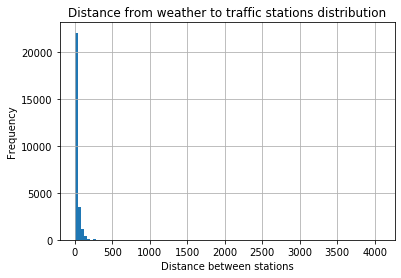

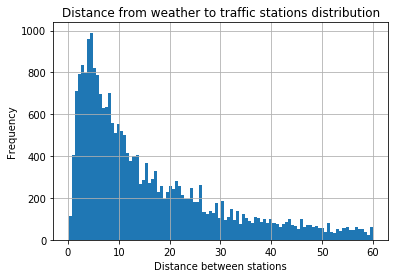

,fips_county_code,fips_state_code,latitude,longitude,station_id,geohash,maslib,wban,lat_prp,lon_prp,dist_lat,dist_long,dist
0,7,15,21.934802,-159.483514,050223,8649486,911650,22536,21.975983,-159.338958,-2.841489,-9.252315,9.678812
2,7,15,21.968091,-159.393066,050015,8649498,911650,22536,21.975983,-159.338958,-0.544548,-3.462375,3.504935
6,7,15,21.966216,-159.357469,051007,8649499,911650,22536,21.975983,-159.338958,-0.673923,-1.184536,1.362827
7,7,15,21.966442,-159.372287,058014,8649499,911650,22536,21.975983,-159.338958,-0.658329,-2.132750,2.232044
11,7,15,21.996166,-159.369934,583004,8649521,911650,22536,21.975983,-159.338958,1.392627,-1.981764,2.422148


In [5]:
geo = '0123456789bcdefghjkmnpqrstuvwxyz'
geomap = {}
for i in range(len(geo)):
    geomap[geo[i]] = i

def base32toint(b32):
    totlen = len(b32)
    total = 0
    for i in range(len(b32)):
        total = total + geomap[b32[i]] * 32 ** (totlen - i - 1)
    return total

def geohasher(row, latcol, loncol):
    return base32toint(Geohash.encode(row[latcol], row[loncol], precision = 5))
    
#get geohash for both station datasets
stationdb.loc[:,'geohash'] = stationdb.apply(lambda row: geohasher(row, 'latitude', 'longitude'), axis = 1)
usiddb.loc[:,'geohash'] = usiddb.apply(lambda row: geohasher(row, 'lat_prp', 'lon_prp'), axis = 1)

stationdb = stationdb.sort_values(by = 'geohash')
usiddb = usiddb.sort_values(by = 'geohash')

combineddf = pd.merge_asof(left = stationdb, right = usiddb, on = 'geohash', direction = 'nearest')

#get distances
combineddf.loc[:,'dist_lat'] = (combineddf['latitude'] - combineddf['lat_prp']) * 69
combineddf.loc[:,'dist_long'] = (combineddf['longitude'] - combineddf['lon_prp']) * 69 * np.cos(combineddf['latitude']*np.pi/180)
combineddf.loc[:,'dist'] = np.sqrt(np.square(combineddf['dist_lat']) + np.square(combineddf['dist_long']))
combineddf['dist'].hist(bins = 100)
plt.title('Distance from weather to traffic stations distribution')
plt.xlabel('Distance between stations')
plt.ylabel('Frequency')
plt.show()
combineddf[combineddf['dist'] < 60]['dist'].hist(bins = 100)
plt.title('Distance from weather to traffic stations distribution')
plt.xlabel('Distance between stations')
plt.ylabel('Frequency')
plt.show()

combineddf.drop(combineddf[combineddf['dist'] > 60].index, inplace = True)
combineddf.drop(['direction_of_travel', 'previous_station_id'], axis = 1, inplace = True)
combineddf.drop_duplicates(inplace = True)
combineddf.loc[:,'wban']= combineddf['wban'].astype(int)
combineddf.loc[:,'maslib']= combineddf['maslib'].astype(int)
combineddf.head()

The geohash merge has worked very well, as the vast majority of distances from traffic to weather stations are within 40 miles. To be safe, I removed all of the rows with distances above 60 miles, where weather data is no longer valid.

Next, we can load in the large traffic database, remove columns we are not using, and sum the data from each station and day so that we have one number for the traffic per location per hour.

In [6]:
trafficdb = pd.read_csv("data/dot_traffic_2015.txt")
trafficdb.drop(trafficdb.columns[[1,3,4,6,7,8,9,10,11,-1]], inplace = True, axis = 1)
trafficdb = trafficdb.groupby(['station_id','fips_state_code','date', 'day_of_week'], as_index = False).sum()
trafficdb.head()

,station_id,fips_state_code,date,day_of_week,traffic_volume_counted_after_0000_to_0100,traffic_volume_counted_after_0100_to_0200,traffic_volume_counted_after_0200_to_0300,traffic_volume_counted_after_0300_to_0400,traffic_volume_counted_after_0400_to_0500,traffic_volume_counted_after_0500_to_0600,...,traffic_volume_counted_after_1400_to_1500,traffic_volume_counted_after_1500_to_1600,traffic_volume_counted_after_1600_to_1700,traffic_volume_counted_after_1700_to_1800,traffic_volume_counted_after_1800_to_1900,traffic_volume_counted_after_1900_to_2000,traffic_volume_counted_after_2000_to_2100,traffic_volume_counted_after_2100_to_2200,traffic_volume_counted_after_2200_to_2300,traffic_volume_counted_after_2300_to_2400
0,000001,8,2015-01-01,5,35,34,18,4,21,31,...,153,135,111,106,104,77,68,68,77,35
1,000001,8,2015-01-02,6,26,40,27,11,28,42,...,277,320,282,257,141,115,130,108,70,65
2,000001,8,2015-01-03,7,58,32,36,16,27,46,...,120,72,105,72,46,52,29,22,16,12
3,000001,8,2015-01-04,1,11,4,8,4,6,20,...,128,152,150,134,82,93,58,55,28,25
4,000001,8,2015-01-05,2,2,9,8,2,16,59,...,257,278,279,269,122,82,72,33,31,16


So, this database contains station ID's, the state code, the date and day of week (for convenience), then the sum of traffic at that station for every hour of the day.

Next, we need to merge this with the traffic database. We can do a simple merge operation on station ID and state code. Then, I convert the date to a different type for comparison with the next database.

In [7]:
combineddf2 = pd.merge(trafficdb, combineddf, on = ['station_id','fips_state_code'])
combineddf2.loc[:,'date'] = combineddf2['date'].str.replace('-','').astype(int)
combineddf2.head()

,station_id,fips_state_code,date,day_of_week,traffic_volume_counted_after_0000_to_0100,traffic_volume_counted_after_0100_to_0200,traffic_volume_counted_after_0200_to_0300,traffic_volume_counted_after_0300_to_0400,traffic_volume_counted_after_0400_to_0500,traffic_volume_counted_after_0500_to_0600,...,latitude,longitude,geohash,maslib,wban,lat_prp,lon_prp,dist_lat,dist_long,dist
0,000001,8,20150101,5,35,34,18,4,21,31,...,40.62971,-102.572141,10409633,725626,24091,40.510325,-101.620147,8.237565,-49.852526,50.528525
1,000001,8,20150102,6,26,40,27,11,28,42,...,40.62971,-102.572141,10409633,725626,24091,40.510325,-101.620147,8.237565,-49.852526,50.528525
2,000001,8,20150103,7,58,32,36,16,27,46,...,40.62971,-102.572141,10409633,725626,24091,40.510325,-101.620147,8.237565,-49.852526,50.528525
3,000001,8,20150104,1,11,4,8,4,6,20,...,40.62971,-102.572141,10409633,725626,24091,40.510325,-101.620147,8.237565,-49.852526,50.528525
4,000001,8,20150105,2,2,9,8,2,16,59,...,40.62971,-102.572141,10409633,725626,24091,40.510325,-101.620147,8.237565,-49.852526,50.528525


Next we can pull out and clean the weather data. This is more complicated, because the data is in many files (~10,000). I use glob to iterate through all the files, then read them in using a whitespace delimiter and names that I provide to avoid indexing errors, and finally concatenate them all. Cleaning involves converting invalid numbers to NaN and removing any special characters that indicate how the data was collected.

In [ ]:
weatherdb = pd.concat([pd.read_csv(f, delim_whitespace = True, skiprows = 1, names = ['STN', 'WBAN','YEARMODA','TEMP','TEMPCount','DEWP','DEWPCount','SLP','SLPCount','STP','STPCount','VISIB','VISIBCount','WDSP','WDSPCount','MXSPD','GUST','MAX','MIN','PRCP','SNDP','FRSHTT']) for f in glob.glob('data/noaa-global-surface-summary-of-the-day/gsod_all_years/*')],axis=0).reset_index()
weatherdb.replace([9999.9,999.9, '9999.9', '999.9', 9999, '9999'], np.nan, inplace = True)
weatherdb['PRCPtype'] = weatherdb['PRCP'].str.replace('\d', '')
weatherdb.loc[:,'PRCP'] = weatherdb['PRCP'].str.replace('\D', '').astype(float)
weatherdb.loc[:,'MAX'] = weatherdb['MAX'].str.replace('*','') #don't really care about whether min was at one moment or over an hour
weatherdb.loc[:,'MIN'] = weatherdb['MIN'].str.replace('*','')
weatherdb.head()

This database includes data on temperature, dewpoint, sea level pressure (SLP), station pressure (STP), visibility, wind speed (WDSP), max wind speed, maximum gust speed, max temperature min temperature, total precipitation, and snow depth.

There appear to be many NaN's, and apparently some of them are due to improper data collection (i.e. there was no snow, and instead of putting 0 they put 999.9). In that case, I will probably have to consider NaN and 0 to be equivalent in some columns.

So now we are ready to do our final merge to put the weather data into the resulting dataframe. We can do another simple merge on station number (both types) and date.

In [ ]:
data = pd.merge(combineddf2, weatherdb, left_on = ['maslib','wban', 'date'], right_on = ['STN','WBAN', 'YEARMODA'])
data['total_traffic_volume'] = data.iloc[:,4:28].sum(axis = 1)
data.head()

We are finally done preparing our data.

## Exploratory Analysis and Data Visualization

There are many weather variables that we can now look at to see their impact on traffic.

### Distributions
We will start by just plotting the distributions of each variable we can look at to see what we are dealing with.

In [ ]:
data['total_traffic_volume'].hist(bins = 100)
plt.title('Traffic volume for all stations and days')
plt.xlabel('Traffic volume')
plt.ylabel('Frequency')
plt.show()

data[data['total_traffic_volume'] < 500000]['total_traffic_volume'].hist(bins = 100)
plt.title('Lower Traffic volume for all stations and days')
plt.xlabel('Traffic volume')
plt.ylabel('Frequency')
plt.show()

We can see that traffic data is extremely right-skewed, with a large number of data points near 0 (probably rural areas), though there are a fair amount of data points that reach above 100,000 cars per day.

In [ ]:
data['TEMP'].hist(bins = 100, label = 'average')
data['MIN'].astype(float).hist(bins = 100, label = 'min', alpha = 0.9)
data['MAX'].astype(float).hist(bins = 100, label = 'max', alpha = 0.7)

plt.title('Temperature for all stations and days')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend()
plt.show()

Temperature is slightly left-skewed, with most data points between 40 degrees Fahrenheit and 80 degrees. Few points comparably get above 90 degrees or below 0.
Min temperature and max temperature are both much more sporadic and are shifted down and up compared to average, respectively.

In [ ]:
data[data['PRCP'] < 250]['PRCP'].hist(bins = 100)
plt.title('Precipitation amount')
plt.xlabel('Precipitation (inches)')
plt.ylabel('Frequency')
plt.show()

Precipitation is clearly right-shifted, becuase most of the time it doesn't rain or snow. There appears to be a strange jigsaw pattern, and some of the data is just unbelievable (above maximum records), so this is likely to be an unreliable data point.

In [ ]:
data['VISIB'].hist(bins = 100)
plt.title('Distribution of Visibility (miles)')
plt.xlabel('Visibility (miles)')
plt.ylabel('Frequency')
plt.show()

Visibility is left-skewed, with most stations appearing to record a maximum of 10 miles, while others do not subscribe to putting a maximum. We may have to ignore data above 10 miles.

### Plots of weather alonside traffic

Now we can look at plots containing both weather and traffic data.

In [ ]:
station1 = data[(data['station_id'] == '638489')] #Michigan
station2 = data[(data['station_id'] == '051131')] #Wisconsin

sns.regplot(station1['day_of_week'], station1['total_traffic_volume'],label = 'MI station') 
sns.regplot(station2['day_of_week'], station2['total_traffic_volume'], label = 'Wisconsin station') 

plt.title('Traffic volume vs date')
plt.legend()
plt.show()

I have randomly sampled 2 stations, one in Michigan, and the other in Wisconsin. Though a little messy, we can see that there is a fairly straightforward relationship between day of week and traffic, where most traffic is during the week when people have to go to work.

In [ ]:
sns.regplot(station1['TEMP'], station1['total_traffic_volume'],label = 'MI station') 
sns.regplot(station2['TEMP'], station2['total_traffic_volume'], label = 'Wisconsin station') 
plt.title('Traffic volume vs temperature')
plt.legend()
plt.show()

The trend with temperature in either does not appear to be too strong, as they both appear to have a set of lower values, meaning some other variable is at play, however the station in Wisconsin indicates a significant relationship.

In [ ]:
sns.regplot(station1['MAX'].astype(float), station1['total_traffic_volume'],label = 'MI station') 
sns.regplot(station2['MAX'].astype(float), station2['total_traffic_volume'], label = 'Wisconsin station') 
plt.title('Traffic volume vs max temperature')
plt.legend()
plt.show()

Max temperature, again, only seems to have a slight correlation with traffic.

In [ ]:
sns.regplot(station1['MIN'].astype(float), station1['total_traffic_volume'],label = 'MI station') 
sns.regplot(station2['MIN'].astype(float), station2['total_traffic_volume'], label = 'Wisconsin station') 
plt.title('Traffic volume vs min temperature')
plt.legend()
plt.show()

From this, we can tell that there is nothing to write home about with regards to temperature, at least in general. However, the association of location and temperature may sometimes be an indicator of traffic.

In [ ]:
sns.regplot(station1['PRCP'].astype(float), station1['total_traffic_volume'],label = 'MI station') 
sns.regplot(station2['PRCP'].astype(float), station2['total_traffic_volume'], label = 'Wisconsin station') 
plt.title('Traffic volume vs precipitation')
plt.legend()
plt.show()

This tells us very little about precipitation and its relationship with traffic. There is no clear correlation.

In [ ]:
sns.regplot(station1['VISIB'].astype(float), station1['total_traffic_volume'],label = 'MI station') 
sns.regplot(station2['VISIB'].astype(float), station2['total_traffic_volume'], label = 'Wisconsin station') 
plt.title('Traffic volume vs visibility')
plt.legend()
plt.show()

There is some slight relationship, but not very strong.

From all this visualization, we have established that there is a slight relationship between traffic and visibility. Sometimes, a relationship between traffic and temperature exists, though there is not much difference between min, max, and average temperatures as a decider. Date, of course, does play a part. From what we can tell at this point, most people don't care what's happening outside, and drive no matter the circumstances, if they were planning to. This is consistent with the fact that most people have jobs that require them to get to work.

## Analysis, Hypothesis Testing, and Machine Learning

Now we can try to do some predictions of weather. I will try this with a decision tree (which I would hope aligns more with how people decide whether to go out). I am going to run it only on one state (Michigan).

In [ ]:
from sklearn.tree import DecisionTreeRegressor

michigan_data= data[data['fips_state_code'] == 55]

X = michigan_data[['date', 'day_of_week', 'TEMP', 'MIN', 'MAX', 'VISIB', 'PRCP']].sample(1000)
y = michigan_data['total_traffic_volume'].sample(1000)

X_test = michigan_data[['station_id', 'date', 'day_of_week', 'TEMP', 'MIN', 'MAX', 'VISIB', 'PRCP']].sample(100)
y_test = michigan_data['total_traffic_volume'].sample(100)
regr = DecisionTreeRegressor()
regr.fit(X, y)

y_pred = regr.predict(X_test)

plt.scatter(y_test, y_pred)

This plot shows how effective the decision tree was by plotting the predicted value against the actual value.

## Insight & Policy Decision

We can gain a couple of insights overall from this project:
 * Traffic data is difficult to predict as a whole. It is very necessary to break down traffic data into regions or smaller to be able to get human-understandable results.
 * Traffic data is influenced by weather, but apparently not by a large extent in most contexts. For most weather, people don't care about what is happening outside.
 * Temperature does have some impact on traffic, but it is possible that this is due to seasonal changes and not due to any 
 * Clearly, many more variables are involved and much more work would have to be done to puzzle over this problem.

## Future Possibilities

 * Further exploration of this data - I have only touched the surface of what can be done with this data alone. Much more work can be done to explore the relationship between traffic and weather.
 * Using hourly data (ftp://ftp.ncdc.noaa.gov/pub/data/noaa/2015/) - This could be more accurate, as sometimes rapid changes in weather do occur within a day and so analyzing this could provide insight on how the timing of weather shifts affects people.
 * Compare to forecast data - It would be interesting to look at whether people rely more on forecast data or actual weather events for deciding whether to go out.
 * Compare to other modes of transportation - Using a car is the main type of transportation in the US, but it is not the only one. Perhaps public transit riders are less impacted or more impacted by weather.
 
#### This is the end of my tutorial on how to prepare and analyze weather and traffic data. Perhaps you can use my data to your advantage when traveling on a rainy day.